<a href="https://colab.research.google.com/github/FredLongo/Big-Data-Analytics-Project/blob/main/Big_Data_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analytics
## Team Project
### Team Members
*   Alfredo Longo
*   Chandramouli Prabhakaran  
*   Cody Zehner
*   Sashank Ganapathy Subramaniam  

### Description
This Project is used to see if we can predict Bitcoin Stock Prices.  In this project we try Several diffrent things to see what can produce the best result.

* We try Two diffrent Time series Model One just one layer and one having three layers

* We also try two diffrent configeration for the (candlestick size) a ten day frame and a 100 day frame

* To give the model more comparitive information to train with we added a Maket indicator to the stock.  We do this so it can have a sence of what the overall market is doing for that day.




#Code Section

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
pip install pandas_ta

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta
"""model libs"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
"""class lib"""
from enum import Enum
""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




The model used is a Long Short-Term Memory model or LSTM. It is a type of recurrent neural network (RNN) architecture used in the field of artificial intelligence, particularly for tasks that involve sequential data. LSTM networks are capable of learning long-term dependencies, which makes them effective for tasks such as time series prediction, natural language processing, and speech recognition.

Here's a brief overview of LSTM:

Long: LSTM networks can remember information for long periods, which is crucial for understanding context over long sequences.
Short-Term: They also handle short-term dependencies effectively, capturing immediate patterns in the data.
Memory: LSTM networks have a memory cell that maintains information over time, along with gates that control the flow of information into and out of the cell.

In [25]:
#The Class Holds are model and all associated data.  This is done so we can compare results.

class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2016-01-01',   # Bitcon only has info back to mid 2015
                 end_date='2024-06-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])
        self.y_test_trend = [0]
        self.y_pred_trend = [0]
        self.scaler = None


        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()


    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)

        # Save Processed input to CSV file for Logging
        current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'/content/drive/MyDrive/Classes/Kent/Big Data Analytics/Data/Input_Data_Processed_{current_datetime}.csv'
        self.data.to_csv(filename , index=False)

    def reverse_scaling(self, data):
        return self.scaler.inverse_transform(data)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        self.scaler = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to our data to make it between 0 and `
        self.data_set_scaled = self.scaler.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
        # This is where we create the model from the configuration given
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

      # Model Training
    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')

    #Predictions on data
    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)


        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


    def calculate_aic(self,y_true, y_pred,n_params):

        mse = mean_squared_error(y_true, y_pred)
        n = len(y_true)
        aic = n * np.log(mse) + 2 * n_params
        return aic



     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

        #AIC
        self.aic = self.calculate_aic(self.y_test,self.y_pred,self.lstm_nodes)




         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print(f'                      AIC ={self.aic}')

        print("")

        #Plot Graph
        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Mean Absolute Error
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')

          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorrect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show



    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [26]:
# Save all the performance data for each model to a CSV file.
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Big Data Analytics/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicators','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean','elapsTime','pred_correctness_mean','AIC']

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicators':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time,
                           "pred_correctness_mean":m.pred_correctness_mean,
                           "AIC":m.aic
                            })


# Get Fields








# Model Fit Section

# Model Training

In [27]:

# Using a market indicator to assit in the prediction.
#Indicators    = '^DJI,^BSESN,^BVSP'
Indicators    = '^DJI'

#BitCoin Stock ID
Ticker = ['BTC']
frame_days = [10,100]
LSTM_layers = [1,2]


Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} model(s)')


Testing 4 model(s)


## Run All the models

This iterates through all the configurations to run all the models we requested

In [28]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  2 of 2 completed


___________BTC_F10_L1___________
Start Time:2024-06-28 21:27:30.929791
Epoch 1/30
48/48 - 12s - loss: 0.1544 - mae: 0.3073 - val_loss: 0.0890 - val_mae: 0.2666 - 12s/epoch - 256ms/step
Epoch 2/30
48/48 - 1s - loss: 0.0382 - mae: 0.1665 - val_loss: 0.0977 - val_mae: 0.2842 - 580ms/epoch - 12ms/step
Epoch 3/30
48/48 - 1s - loss: 0.0141 - mae: 0.0964 - val_loss: 0.0736 - val_mae: 0.2454 - 599ms/epoch - 12ms/step
Epoch 4/30
48/48 - 1s - loss: 0.0088 - mae: 0.0705 - val_loss: 0.0567 - val_mae: 0.2175 - 519ms/epoch - 11ms/step
Epoch 5/30
48/48 - 0s - loss: 0.0076 - mae: 0.0671 - val_loss: 0.0484 - val_mae: 0.2022 - 447ms/epoch - 9ms/step
Epoch 6/30
48/48 - 1s - loss: 0.0075 - mae: 0.0673 - val_loss: 0.0460 - val_mae: 0.1979 - 622ms/epoch - 13ms/step
Epoch 7/30
48/48 - 0s - loss: 0.0079 - mae: 0.0699 - val_loss: 0.0465 - val_mae: 0.1992 - 426ms/epoch - 9ms/step
Epoch 8/30
48/48 - 1s - loss: 0.0083 - mae: 0.0723 - val_loss: 0.0479 - val_mae: 0.2023 - 628ms/epoch - 13ms/step
Epoch 9/30
48/48 - 

[*********************100%%**********************]  2 of 2 completed


___________BTC_F10_L2___________
Start Time:2024-06-28 21:28:22.302860
Epoch 1/30
48/48 - 5s - loss: 0.2868 - mae: 0.4164 - val_loss: 0.0864 - val_mae: 0.2748 - 5s/epoch - 106ms/step
Epoch 2/30
48/48 - 1s - loss: 0.0513 - mae: 0.1965 - val_loss: 0.0992 - val_mae: 0.2980 - 513ms/epoch - 11ms/step
Epoch 3/30
48/48 - 1s - loss: 0.0183 - mae: 0.1193 - val_loss: 0.0822 - val_mae: 0.2681 - 505ms/epoch - 11ms/step
Epoch 4/30
48/48 - 0s - loss: 0.0159 - mae: 0.1087 - val_loss: 0.0806 - val_mae: 0.2646 - 494ms/epoch - 10ms/step
Epoch 5/30
48/48 - 0s - loss: 0.0168 - mae: 0.1134 - val_loss: 0.0779 - val_mae: 0.2589 - 494ms/epoch - 10ms/step
Epoch 6/30
48/48 - 1s - loss: 0.0158 - mae: 0.1104 - val_loss: 0.0746 - val_mae: 0.2522 - 506ms/epoch - 11ms/step
Epoch 7/30
48/48 - 0s - loss: 0.0141 - mae: 0.1042 - val_loss: 0.0694 - val_mae: 0.2417 - 482ms/epoch - 10ms/step
Epoch 8/30
48/48 - 1s - loss: 0.0122 - mae: 0.0964 - val_loss: 0.0630 - val_mae: 0.2289 - 513ms/epoch - 11ms/step
Epoch 9/30
48/48 - 

[*********************100%%**********************]  2 of 2 completed


___________BTC_F100_L1___________
Start Time:2024-06-28 21:28:45.033475
Epoch 1/30
44/44 - 5s - loss: 0.1087 - mae: 0.2676 - val_loss: 0.0746 - val_mae: 0.2601 - 5s/epoch - 110ms/step
Epoch 2/30
44/44 - 2s - loss: 0.0426 - mae: 0.1777 - val_loss: 0.0565 - val_mae: 0.2279 - 2s/epoch - 54ms/step
Epoch 3/30
44/44 - 2s - loss: 0.0202 - mae: 0.1254 - val_loss: 0.0383 - val_mae: 0.1856 - 2s/epoch - 39ms/step
Epoch 4/30
44/44 - 1s - loss: 0.0147 - mae: 0.1057 - val_loss: 0.0341 - val_mae: 0.1738 - 1s/epoch - 32ms/step
Epoch 5/30
44/44 - 1s - loss: 0.0161 - mae: 0.1114 - val_loss: 0.0344 - val_mae: 0.1749 - 1s/epoch - 32ms/step
Epoch 6/30
44/44 - 1s - loss: 0.0165 - mae: 0.1127 - val_loss: 0.0335 - val_mae: 0.1725 - 1s/epoch - 32ms/step
Epoch 7/30
44/44 - 1s - loss: 0.0152 - mae: 0.1075 - val_loss: 0.0313 - val_mae: 0.1666 - 1s/epoch - 32ms/step
Epoch 8/30
44/44 - 1s - loss: 0.0132 - mae: 0.0994 - val_loss: 0.0289 - val_mae: 0.1596 - 1s/epoch - 32ms/step
Epoch 9/30
44/44 - 1s - loss: 0.0113 - 

[*********************100%%**********************]  2 of 2 completed


___________BTC_F100_L2___________
Start Time:2024-06-28 21:29:38.677998
Epoch 1/30
44/44 - 15s - loss: 0.1588 - mae: 0.2984 - val_loss: 0.0746 - val_mae: 0.2569 - 15s/epoch - 330ms/step
Epoch 2/30
44/44 - 3s - loss: 0.0463 - mae: 0.1809 - val_loss: 0.0665 - val_mae: 0.2412 - 3s/epoch - 66ms/step
Epoch 3/30
44/44 - 3s - loss: 0.0176 - mae: 0.1131 - val_loss: 0.0518 - val_mae: 0.2121 - 3s/epoch - 70ms/step
Epoch 4/30
44/44 - 3s - loss: 0.0142 - mae: 0.1013 - val_loss: 0.0474 - val_mae: 0.2022 - 3s/epoch - 70ms/step
Epoch 5/30
44/44 - 5s - loss: 0.0100 - mae: 0.0817 - val_loss: 0.0407 - val_mae: 0.1869 - 5s/epoch - 109ms/step
Epoch 6/30
44/44 - 3s - loss: 0.0079 - mae: 0.0699 - val_loss: 0.0333 - val_mae: 0.1687 - 3s/epoch - 76ms/step
Epoch 7/30
44/44 - 3s - loss: 0.0090 - mae: 0.0802 - val_loss: 0.0298 - val_mae: 0.1594 - 3s/epoch - 70ms/step
Epoch 8/30
44/44 - 3s - loss: 0.0068 - mae: 0.0693 - val_loss: 0.0248 - val_mae: 0.1451 - 3s/epoch - 66ms/step
Epoch 9/30
44/44 - 4s - loss: 0.0086

# Report Section

In [29]:
# Print  Main performance indicators on each model

for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: BTC_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.040896649930896305
             mean_sqr_err =0.002886401189691506
        root_mean_sqr_err =0.053725237921218236
           pred_diff_mean =0.9876202724289609
      pred_diff_bias_mean =0.012379727571039166
    pred_correctness_mean =0.994475138121547
                      AIC =-1016.441811682364

############################################################################
  Model Setup:
                    Name: BTC_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  

############################################################################
  Model Setup:
                    Name: BTC_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.040896649930896305
             mean_sqr_err =0.002886401189691506
        root_mean_sqr_err =0.053725237921218236
           pred_diff_mean =0.9876202724289609
      pred_diff_bias_mean =0.012379727571039166
    pred_correctness_mean =0.994475138121547
                      AIC =-1016.441811682364



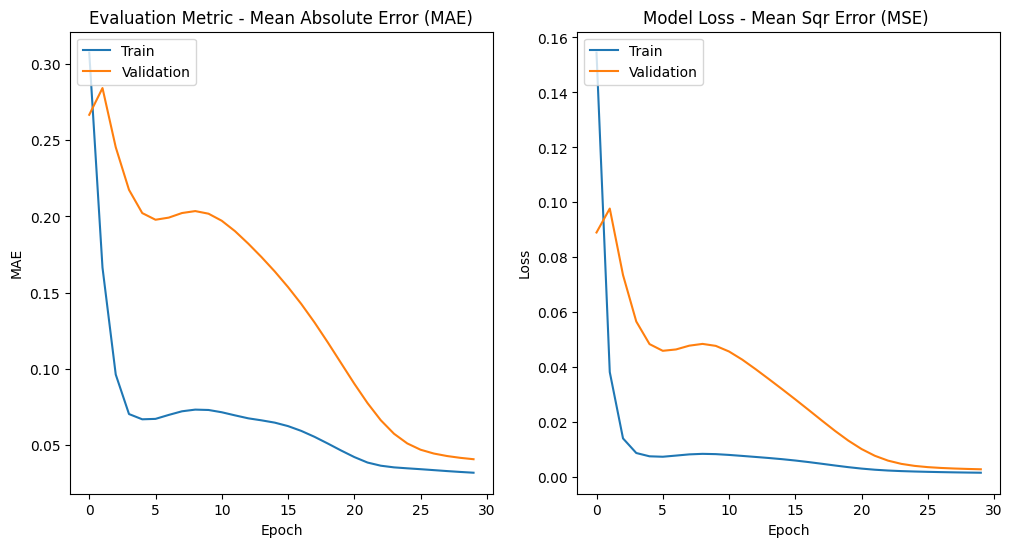

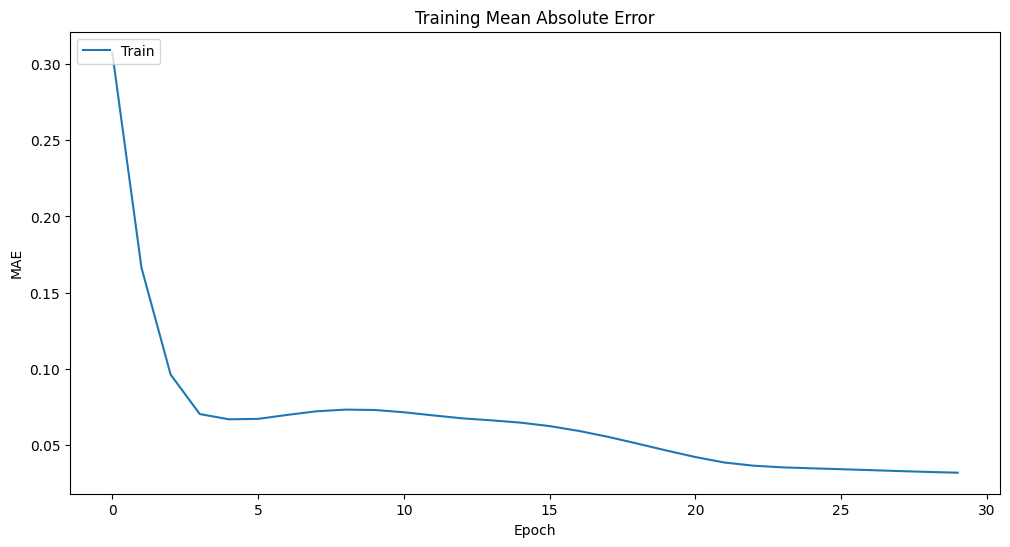

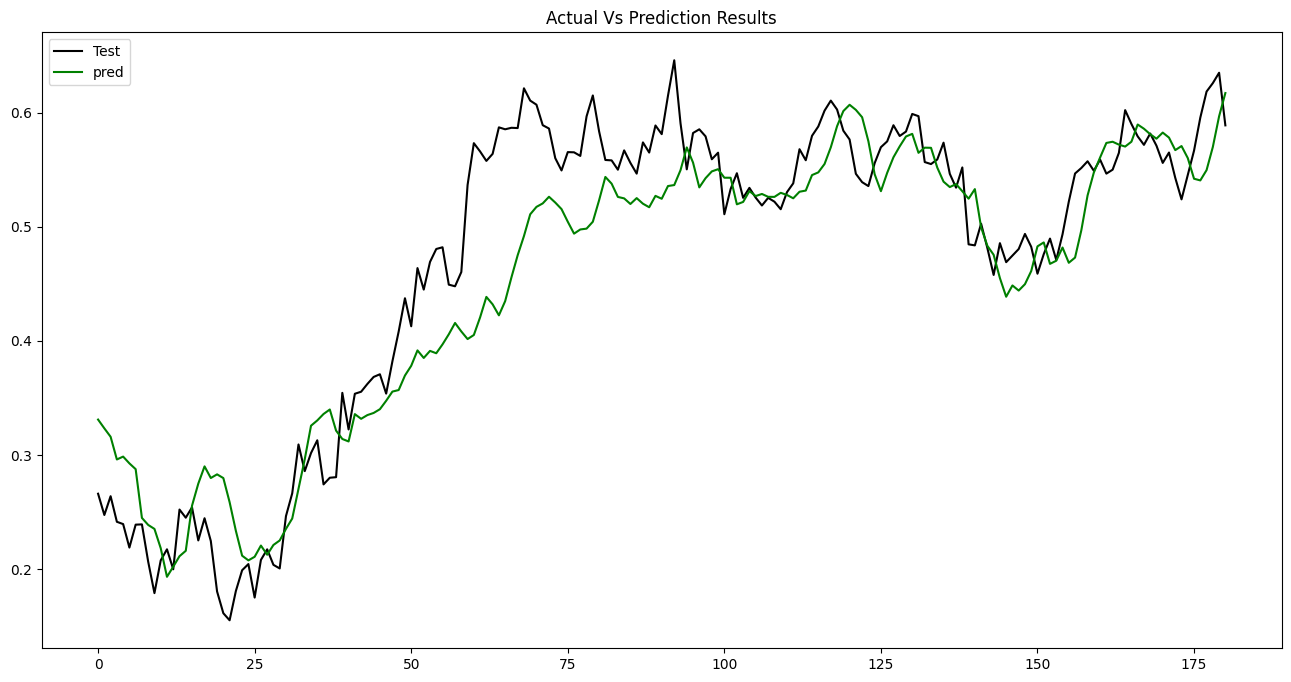

############################################################################
  Model Setup:
                    Name: BTC_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.09658458249627273
             mean_sqr_err =0.011556531113612786
        root_mean_sqr_err =0.10750130749722436
           pred_diff_mean =0.8988672351214806
      pred_diff_bias_mean =0.10113276487851938
    pred_correctness_mean =0.994475138121547
                      AIC =-765.3513212779097



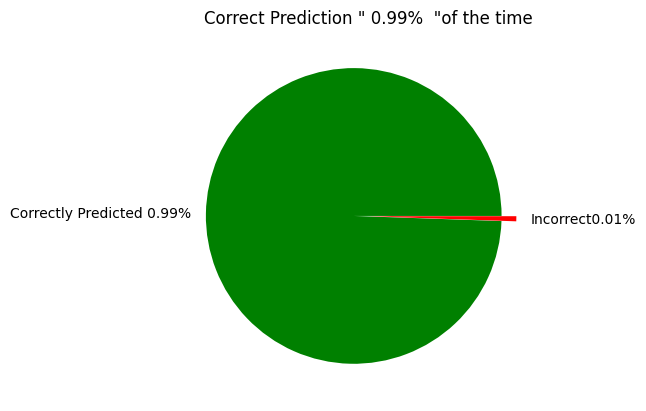

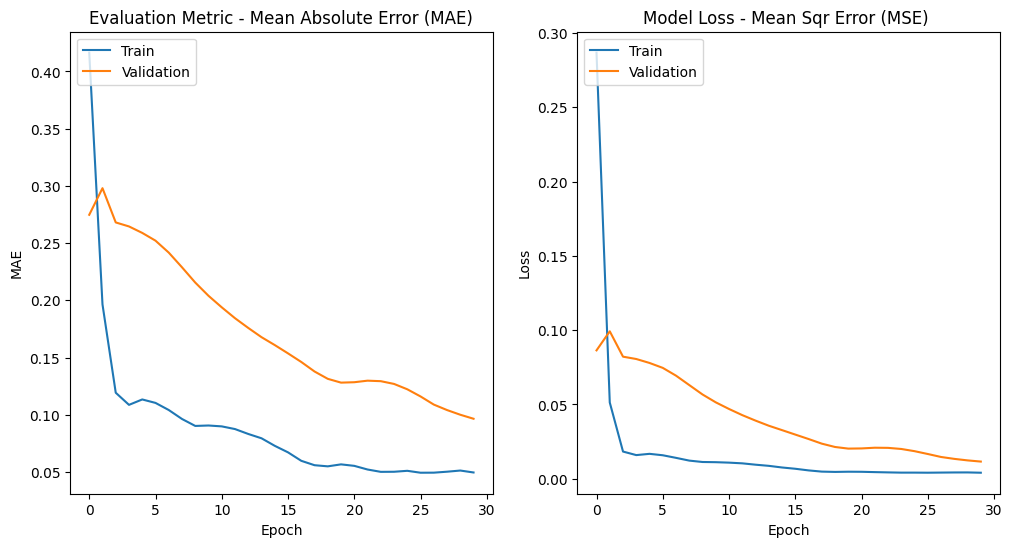

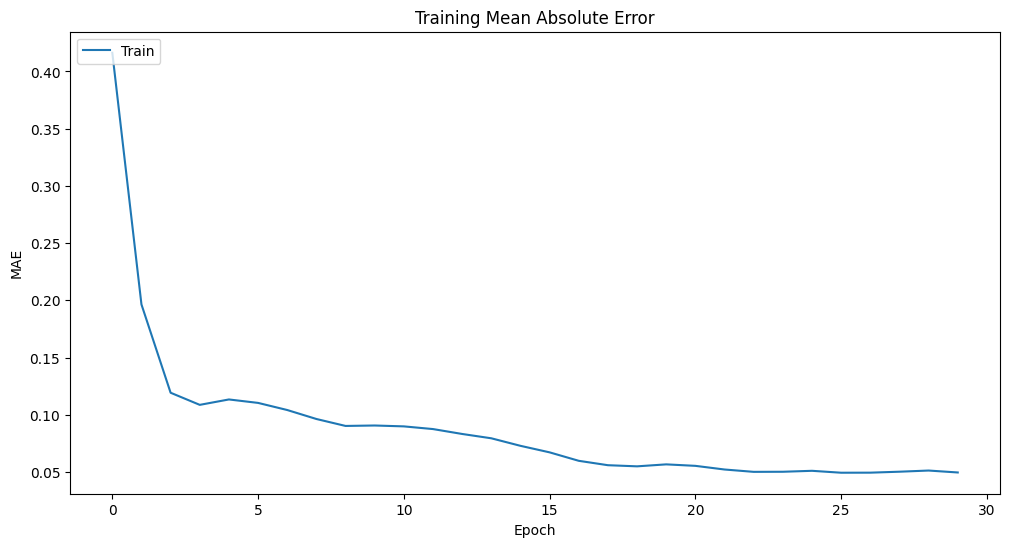

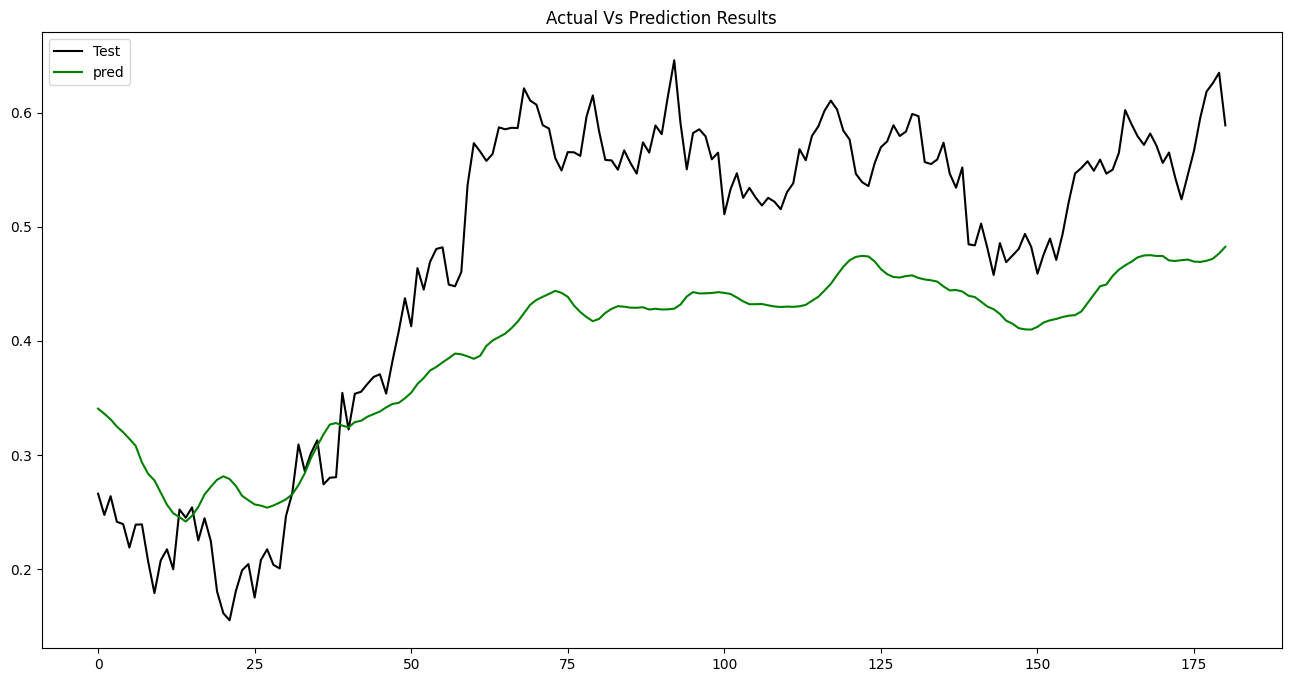

############################################################################
  Model Setup:
                    Name: BTC_F100_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.06921542374602502
             mean_sqr_err =0.0058299159216748915
        root_mean_sqr_err =0.07635388609412681
           pred_diff_mean =0.8843878328713246
      pred_diff_bias_mean =0.1156121671286755
    pred_correctness_mean =0.9815950920245399
                      AIC =-796.5946901638705



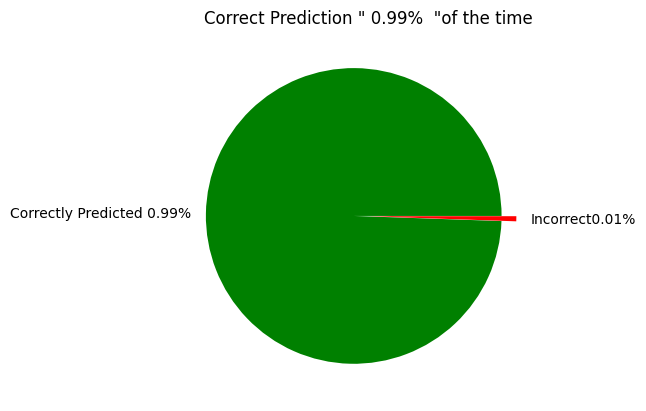

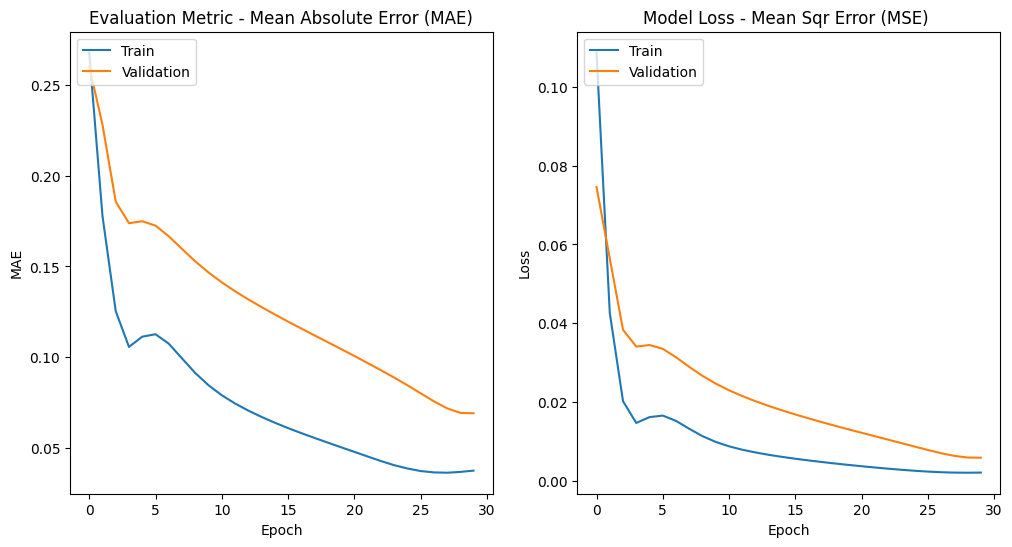

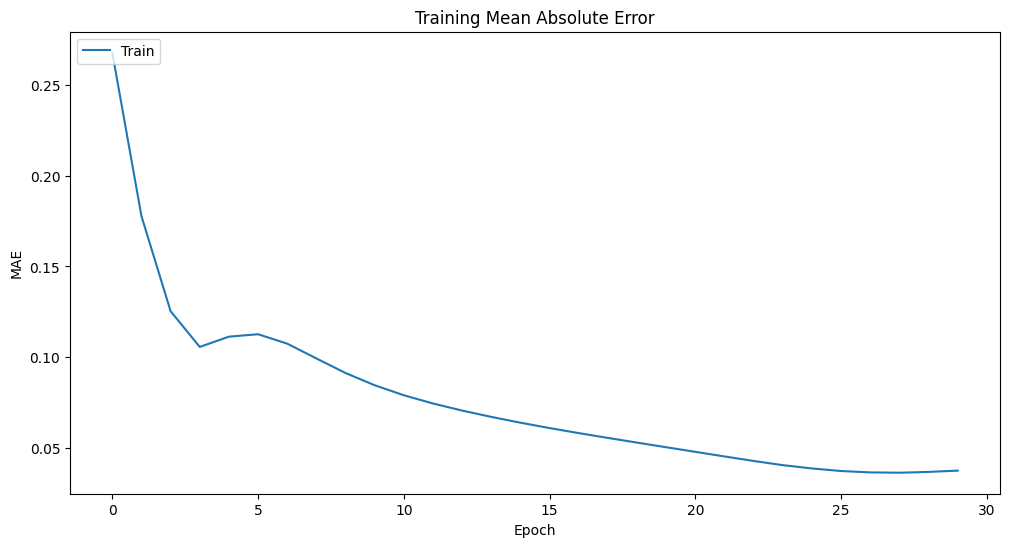

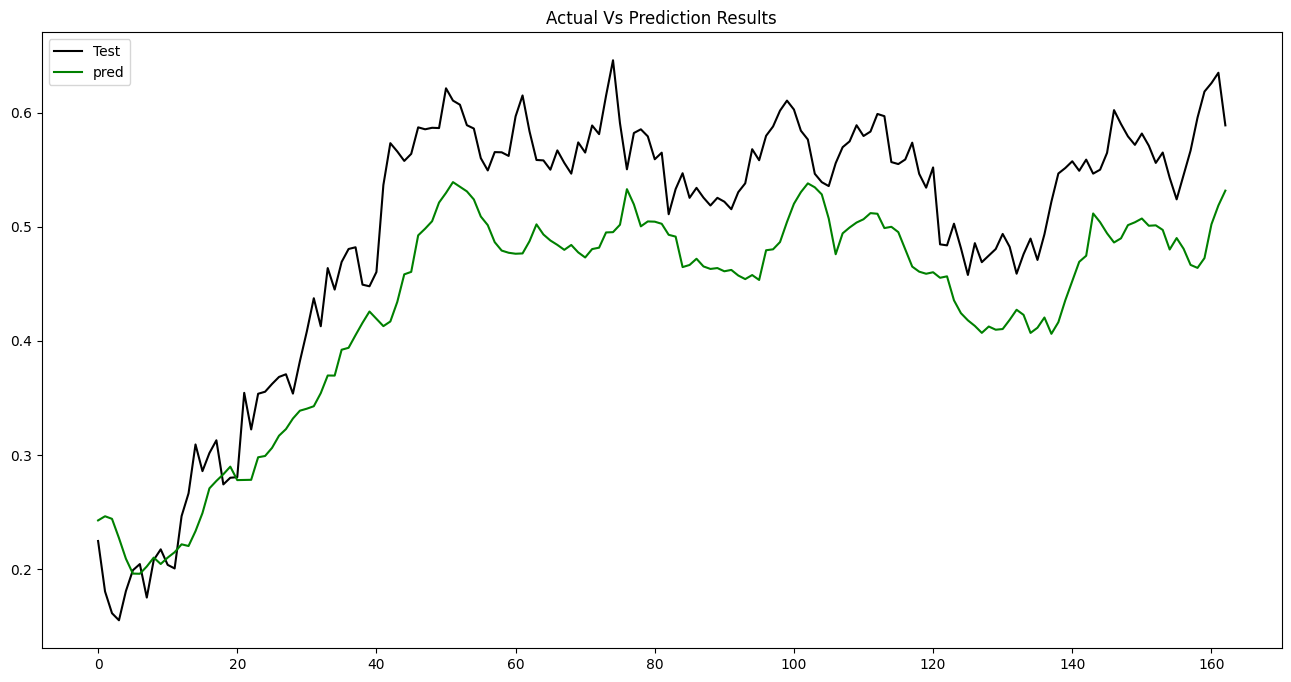

############################################################################
  Model Setup:
                    Name: BTC_F100_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.10957187627306178
             mean_sqr_err =0.014432911852530862
        root_mean_sqr_err =0.12013705445253292
           pred_diff_mean =0.8486148699643294
      pred_diff_bias_mean =0.15138513003567064
    pred_correctness_mean =0.9754601226993865
                      AIC =-648.8337940003317



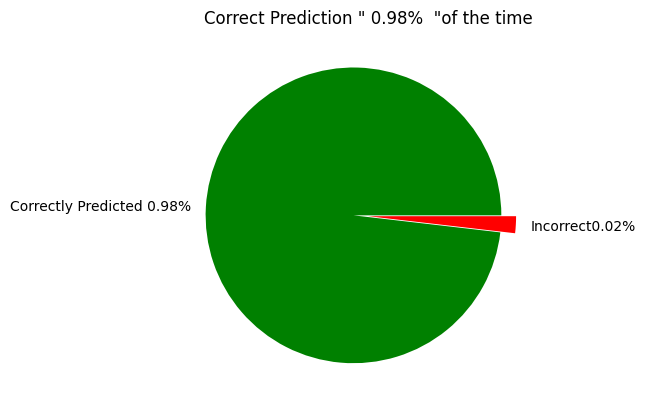

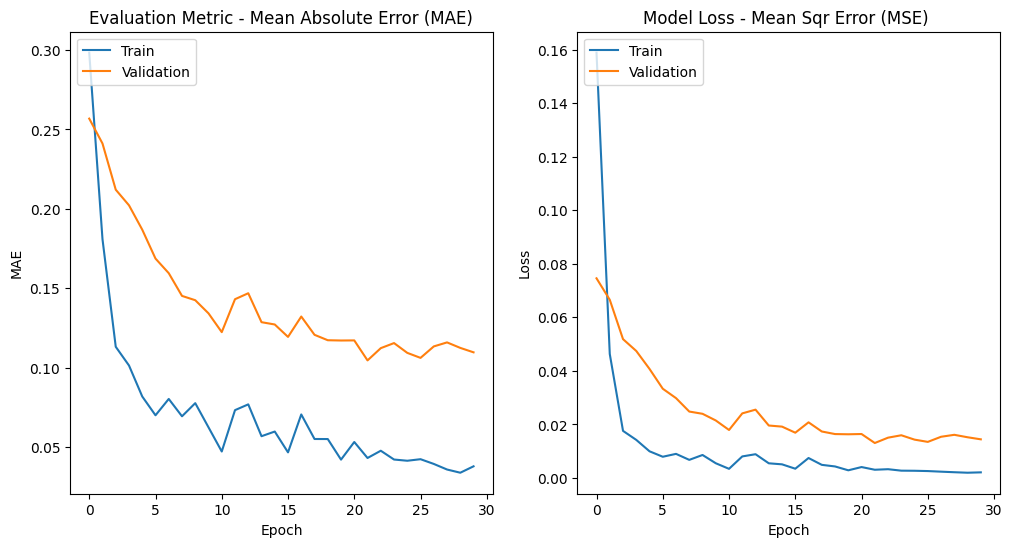

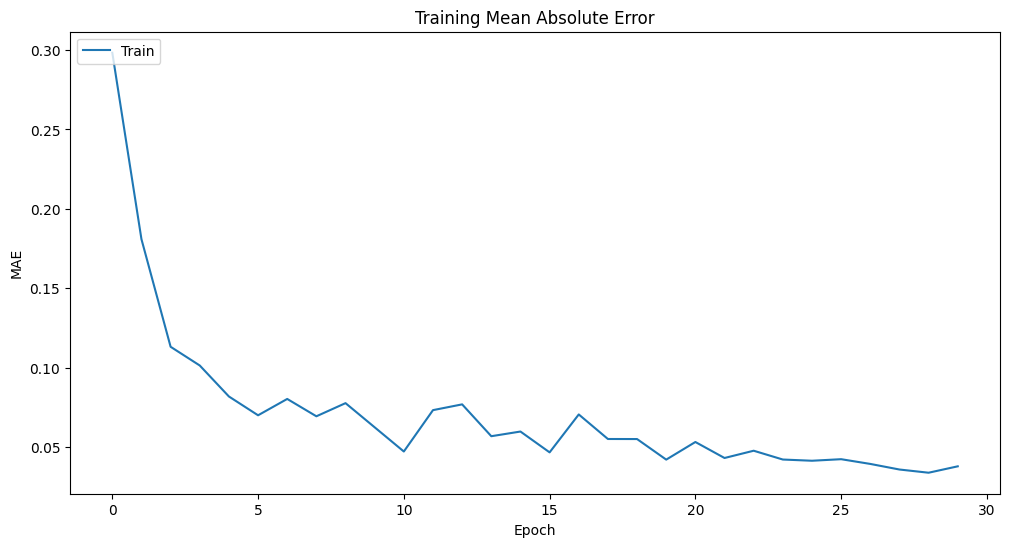

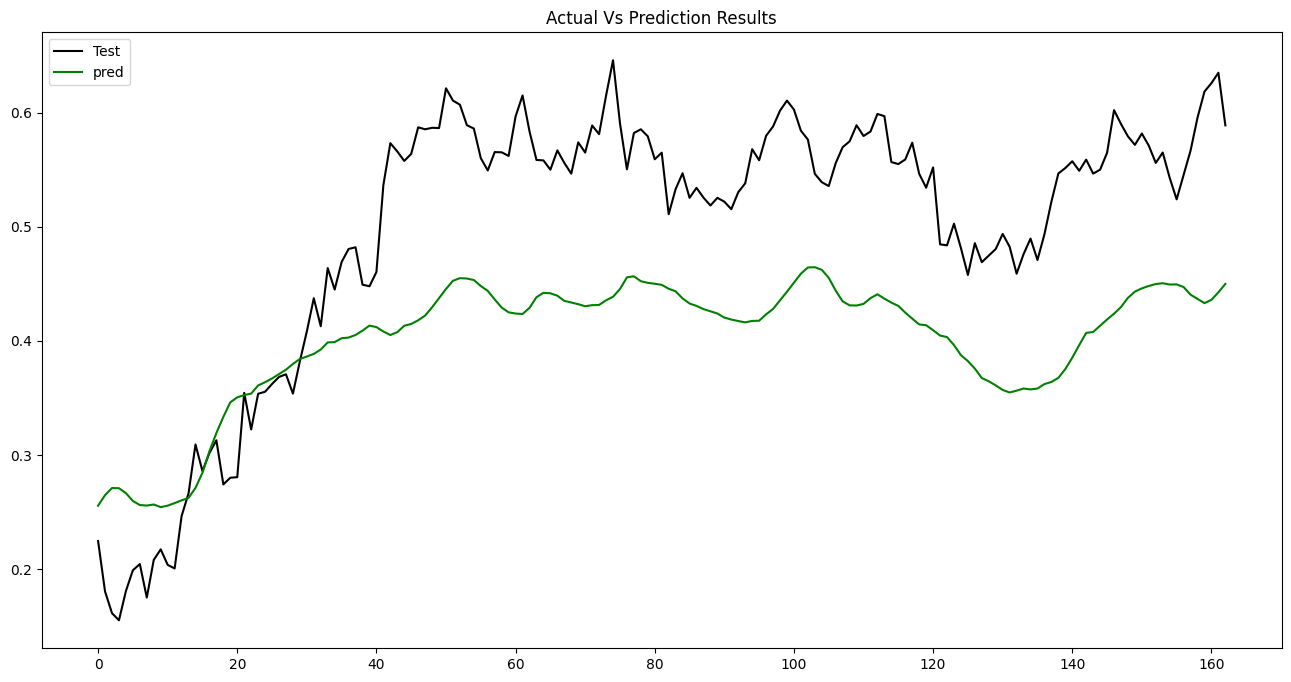

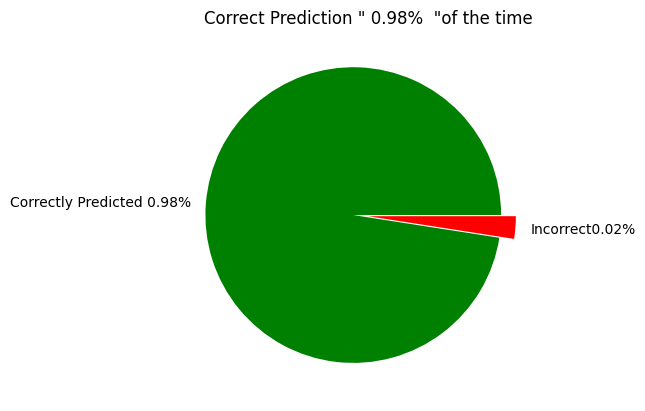

In [30]:
# Graph training and testing results on each model

for m in model_list:
  m.View_Performance_Report(show_graphs=True)


The reports above indicate that our first model, utilizing a candle frame of 10 and a single layer, performed the best.

For that model "BTC_F10_L1" it prediction shows it is correct 99% of the time.

However, I am not comfortable with this result. Despite achieving a high level of predictions, it does not necessarily mean we are successful.  

Upon examining the graphs, it appears that our predictions are merely following the current trend. Therefore, I propose testing a strategy based on trading in accordance with the predictions provided.

Initially, I record the current value and determine whether the trend from the current to the predicted value is upward or downward. If the trend is upward, I buy, anticipating that the price will increase. If the trend is downward, I sell. If there is no significant trend, I take no action. This market strategy is known as "Trend Following."

To set up the scenario, I assume an initial holding of 1,000 shares of the stock. This buffer is necessary because the extent of buying or selling is uncertain. Additionally, I allocate $100,000 to start, providing capital for purchasing stocks. At the end of the simulation, I will evaluate the combined value of my stocks and cash. This assessment will indicate whether we have gained or lost in net worth. I run this accross all the models just to confirm consistancy in my understanding of the data.

In [31]:
#  Class to standerize trend direction
class CheckDir:
  class Direction(Enum):
    UP = 1
    DOWN = -1
    NONE = 0

  @staticmethod
  def get_direction(last:float,current:float):
    if last < current:
      return CheckDir.Direction.UP
    elif last > current:
      return CheckDir.Direction.DOWN
    else:
      return CheckDir.Direction.NONE

In [33]:


class TradingSimulation:
    def __init__(self, model, shares=1000, cash=100000, buy_sell_amount=10):
        self.model = model
        self.shares = shares
        self.cash = cash
        self.buy_sell_amount = buy_sell_amount
        self.buy_counter = 0
        self.sell_counter = 0
        self.data_length = len(model.y_test)
        self.price_start = model.data_set.iloc[0, 0]
        self.price = self.price_start
        print('--------------------------')
        print(f'Model:{self.model.name}')

    def set_trend(self):
        self.model.y_pred_trend[0] = CheckDir.Direction.NONE
        self.model.y_test_trend[0] = CheckDir.Direction.NONE

        for i in range(1, self.data_length):
            self.model.y_pred_trend.append(CheckDir.get_direction(self.model.y_pred[i-1], self.model.y_pred[i]))
            self.model.y_test_trend.append(CheckDir.get_direction(self.model.y_test[i-1], self.model.y_test[i]))

        # Report to visually check for key data markers
        #print(f"         Predicted                                        |Key|R|Key|                         Test ")
        #print(f" Last  |   (trend)         |   Current   |   (trend)      |   | |   |    Last  |   (trend)         |   Current   |   (trend)         ")
        for i in range(1, self.data_length):
            pl = self.model.y_pred[i-1]
            pld = self.model.y_pred_trend[i-1]
            pc = self.model.y_pred[i]
            pcd = self.model.y_pred_trend[i]
            pk = " " if pld == pcd else "*"

            tl = self.model.y_test[i-1]
            tld = self.model.y_test_trend[i-1]
            tc = self.model.y_test[i]
            tcd = self.model.y_test_trend[i]
            tk = " " if tld == tcd else "*"

            r = " " if pcd == tcd else "F"

            # Extract the numerical values, format them, and ensure 5 decimal places
         #   print(f"{pl[0]:0.5f},   {str(pld):15s},   {pc[0]:0.5f},   {str(pcd):15s}  | {pk} |{r}| {tk} |    {tl[0]:0.5f},   {str(tld):15s},   {tc[0]:0.5f},   {str(tcd):15s}")



    def buy(self, price):
        cost = self.buy_sell_amount * price
        self.cash -= cost
        self.shares += self.buy_sell_amount
        self.buy_counter += 1

    def sell(self, price):
        cost = self.buy_sell_amount * price
        self.cash += cost
        self.shares -= self.buy_sell_amount
        self.sell_counter += 1

    def run_simulation(self):
        print(f'Start simulation for  {self.model.name} ')

        for i in range(len(self.model.y_test)):
            if i > 0: # because we need one to compare against
                pcd = self.model.y_pred_trend[i]
                self.price = self.model.data_set.iloc[i, 0]

                if pcd == CheckDir.Direction.UP:  # If trending the same not a key indicator
                    self.buy(self.price)
                    #print(f"BUY  {self.model.y_test[i][0]:.4f}  Cash:{self.cash:.2f}    Shares:{self.shares}  Price:{self.price}  Stock Value:{(self.shares * self.price)}  Value:{((self.shares * self.price) + self.cash):.2f}       ")
                elif pcd == CheckDir.Direction.DOWN:  # trending direction shifted, Key Indicator
                    self.sell(self.price)
                    #print(f"SELL {self.model.y_test[i][0]:.4f}  Cash:{self.cash:.2f}    Shares:{self.shares}  Price:{self.price}  Stock Value:{(self.shares * self.price)}  Value:{((self.shares * self.price) + self.cash):.2f}        ")

        print(f"\nFinal buy:{self.buy_counter}  sell:{self.sell_counter}  Cash:{self.cash}  Shares:{self.shares}  ....>  Traded Stock Value:    ${(self.shares * self.price):,.2f}   Traded Total Value:    ${(self.shares * self.price) + self.cash:,.2f}        ")
        print(f'Price Start: ${self.price_start:.4f}                                       ....>  Untraided Stock Value: ${self.price_start * 1000:,.2f}    Untrained Total Value: ${(self.price_start * 1000) + 100000:,.2f}')

# Assuming CheckDir is already defined and available
# Usage example:
for model in model_list:
    simulation = TradingSimulation(model)
    simulation.set_trend()
    simulation.run_simulation()



--------------------------
Model:BTC_F10_L1
Start simulation for  BTC_F10_L1 

Final buy:102  sell:78  Cash:77179.86625671387  Shares:1240  ....>  Traded Stock Value:    $117,425.19   Traded Total Value:    $194,605.05        
Price Start: $95.2643                                       ....>  Untraided Stock Value: $95,264.33    Untrained Total Value: $195,264.33
--------------------------
Model:BTC_F10_L2
Start simulation for  BTC_F10_L2 

Final buy:102  sell:78  Cash:77136.1124420166  Shares:1240  ....>  Traded Stock Value:    $117,425.19   Traded Total Value:    $194,561.30        
Price Start: $95.2643                                       ....>  Untraided Stock Value: $95,264.33    Untrained Total Value: $195,264.33
--------------------------
Model:BTC_F100_L1
Start simulation for  BTC_F100_L1 

Final buy:93  sell:69  Cash:77122.69424438477  Shares:1240  ....>  Traded Stock Value:    $117,390.34   Traded Total Value:    $194,513.04        
Price Start: $95.2643                    

For model BTC_F10_L1 did perform the best out of all the models.  However it did not perform as well as just holding the 1000 shares and not trading.  Theirfor we find that although are model can predict the outcome 99% of the time it is not helpfull in defining trading.  Because the AI system simply learned to do Treand Trading.